# LSP Ti-6Al-4V Depth Stress Scan

This notebook presents an example analysis of residual stresses at P61A.

###### Sample:
100 × 20 × 1 mm thick Ti-6Al-4V sheet with Laser Shock Peening treated surface.

###### Experiment parameters:
Measurements in transmission.
Incident beam 50 × 50 μm, detector 2Θ = 5.274° calibrated using NIST 640f Si powder.

###### Experimental procedure:
1. Orient the sample with surface parallel to the beam at half of the beam height.
2. Rotate the sample by Θ, so that the incident and diffracted beam fall at the same angle.
3. Perform *eu.chi* scan for every *eu.z* position for two *eu.phi* orientations 0° and 90°. *eu.z* puts the gauge volume at a certain depth in the sample, and for each depth a $sin^2(\psi)$ scan is performed for $\varphi \in \{0^{\circ}, 90^{\circ}\}$. For the purposes of $sin^2(\psi)$ method, *eu.phi* is $\varphi$ and *eu.chi* is $\psi$.
4. Diffraction patterns were analysed using P61A::Viewer. Peaks exported from the Viewer are the starting point of this analysis.

## Imports

In [8]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from uncertainties import unumpy, ufloat

# This has to be the path to P61AToolkit/src/py61a.
# If you are launching the notebook from P61AToolkit/src/notebooks it is correct,
# otherwise change it accordingly.
sys.path.append('../py61a')
from py61a.viewer_utils import read_peaks, valid_peaks, peak_id_str, group_by_motors
from py61a.cryst_utils import bragg, tau, mu
from py61a.stress import sin2psi, deviatoric_stresses

%matplotlib inline

## Definitions

In [9]:
# 2Theta angle
tth_ch1 = 5.274
# Main element in the alloy, will be used for absorption calculation
element = 'Ti'
# Diffraction elactic constants prepared using ISODEC https://www.nist.gov/services-resources/software/isodec
dec = pd.read_csv(r'../../data/dec/alphaTi.csv', index_col=None, comment='#')

## $d_0$ measurement preparation
A reference sample was measured to get the $d_0$ values for the diffraction peaks.

In [10]:
# read Viewer output
d0_data = read_peaks(r'../../data/peaks/TiLSP/Ti_1mm_d0_ref.csv')
# create a dataframe for storing d0 values
d0 = pd.DataFrame(columns=['h', 'k', 'l', 'd0', 'd0_std', 'en'])
for peak_id in valid_peaks(d0_data, valid_for='phase'):
    # calculating the d value from the peak center and 2Theta
    d_val = bragg(en=ufloat(d0_data[peak_id]['center'].mean(), d0_data[peak_id]['center'].std()), tth=tth_ch1)['d']
    # adding to the d0 dataframe as a new row
    d0.loc[d0.shape[0]] = {
        **{idx: d0_data[peak_id][idx].mean().astype(int) for idx in ('h', 'k', 'l')},
        'd0': d_val.nominal_value,
        'd0_std': d_val.std_dev,
        'en': d0_data[peak_id]['center'].mean()
    }
# showing results: hkl, measured d0, measured d0 standard deviation, energy of the peak
d0 = d0.sort_values(by='en').reset_index(drop=True)
print(d0)

    h  k  l        d0    d0_std          en
0   1  0  0  2.532843  0.000550   53.197829
1   0  0  2  2.335838  0.000622   57.684555
2   1  0  1  2.227108  0.000479   60.500767
3   1  0  2  1.717717  0.000366   78.442366
4   1  1  0  1.463043  0.000455   92.096946
5   1  0  3  1.327186  0.000373  101.524369
6   2  0  0  1.267117  0.000715  106.337267
7   1  1  2  1.240123  0.000234  108.651924
8   2  0  1  1.222798  0.000458  110.191368
9   0  0  4  1.168465  0.000659  115.315181
10  2  0  2  1.113966  0.000360  120.956806


C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\numpy\lib\function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

h    2
k    1
l    0
dtype: int32 not found in provided DEC dataset! consider adding it
h    2
k    0
l    0
dtype: int32 not found in provided DEC dataset! consider adding it
h    2
k    0
l    3
dtype: int32 not found in provided DEC dataset! consider adding it
h    2
k    0
l    1
dtype: int32 not found in provided DEC dataset! consider adding it
h    1
k    1
l    2
dtype: int32 not found in provided DEC dataset! consider adding it
[111.33900112 102.51708242 104.31461129  96.87667528 103.491974
 122.76257614  67.74761025  44.23959656  53.49716148  23.67949104
  41.17078327  40.7009592   27.16044993  22.07018186  25.70102724
  33.42080986  50.02220051  56.58044596  37.1651527   54.68695527
  55.60704294  53.14490672  40.25616938  38.42729381  38.95794424
  43.8593857   67.16457418]
[111.36130227 119.80888219  83.6082668   78.85176579  78.46825972
  89.8454832   65.29514231  49.1744203   49.96962064  55.19616752
  37.00427701  44.75354565  25.24873037  30.11637273  39.58827124
  35.7

C:\Users\dovzheng\Anaconda3\envs\P61AToolkit\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[102.48424779 128.06370762 110.07037728 101.65450145  84.61112733
  74.97690228  78.0535412   76.63283897  63.02036822  24.6291424
  34.81676684  18.1689794   29.16809559  22.80858218  22.32936374
  35.2288001   29.02307801  36.77778563  41.44251387  37.03201957
  31.22908038  38.34814716  36.21974759  22.84260315  23.25851314
  34.78745707  54.43474454]
[133.38194084 137.34438359 145.43484881 102.76619858 129.70420761
 113.77636365  91.27131378  64.39634276  33.94397823  30.04079425
  28.22052086  18.780057    12.33566391   7.56817279  32.1849962
  39.95538743  36.23610647  45.71504849  54.80860196  52.37185943
  36.10476858  34.21240781  49.49231737  35.15335979  20.79800943
  34.68594526  67.94985824]
[129.68283608  74.15525867 127.09043219 122.35038241 109.541315
 134.2107482  115.74349659  40.40142879  57.61397391  28.34087489
  50.92003428  41.67286889  30.66319071  30.91577799  20.76779885
  58.12566804  54.01413785  38.79951042  46.0583281   63.82963249
  48.49311009  43.841994

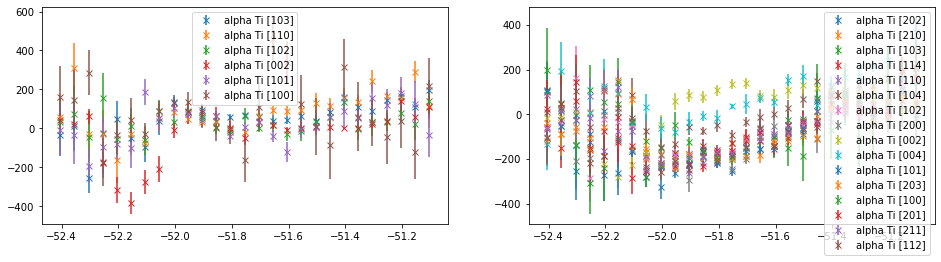

In [11]:
# Reading the Viewer output. Multiple files can be passed to read_peaks function as a tuple
dd = read_peaks((r'../../data/peaks/TiLSP/phi0Trans_3.csv', r'../../data/peaks/TiLSP/phi90Trans_4.csv'))

for peak_id in valid_peaks(dd, valid_for='sin2psi'):
    d_val = bragg(en=unumpy.uarray(dd[(peak_id, 'center')], dd[(peak_id, 'center_std')]), tth=tth_ch1)['d']
    dd[(peak_id, 'd')] = unumpy.nominal_values(d_val)
    dd[(peak_id, 'd_std')] = unumpy.std_devs(d_val)

# defining the scan: it was over eu.z
dd = group_by_motors(dd, motors=[{'mot_name': 'eu.z', 'atol': 1e-3}])

analysis = sin2psi(dataset=dd, phi_col='eu.phi', phi_atol=5.,
                   psi_col='eu.chi', psi_atol=.1, psi_max=90.)

stress = deviatoric_stresses(dd, analysis, dec)
stress = stress.reset_index()
stress.set_index('eu.z', inplace=True)
z_pos = dd[[('scanpts', 'eu.z'), ('md', 'eu.z')]].groupby(by=('scanpts', 'eu.z')).mean()

plt.figure(figsize=(16, 4))
for peak_id in set(stress.columns.get_level_values(0)):
    ax1, ax2 = plt.subplot(121), plt.subplot(122)

    if 's11-s33' in stress[peak_id].columns:
        ax1.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's11-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's11-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )
        
    if 's22-s33' in stress[peak_id].columns:
        ax2.errorbar(
            x=z_pos.loc[stress.index].values.flatten(),
            y=unumpy.nominal_values(stress.loc[:, (peak_id, 's22-s33')]),
            yerr=unumpy.std_devs(stress.loc[:, (peak_id, 's22-s33')]),
            marker='x', linestyle='', label=peak_id_str(dd, peak_id)
        )

ax1.legend()
ax2.legend()
plt.show()

In [12]:
print(read_peaks(r'../../data/peaks/TiLSP/phi90Trans_4.csv').shape)
print(read_peaks(r'../../data/peaks/TiLSP/phi0Trans_3.csv').shape)

(567, 396)
(567, 206)
